In [1]:
!pip install lime
!pip install shap
import shap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import time
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import seaborn as sns

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_data(annotation_file, physiological_file):
    # Read annotation data
    annotation_data = pd.read_csv(annotation_file)

    # Classify emotion based on valence and arousal
    def classify_emotion(arousal, valence):
        arousal_bins = [-26225, -13112, 0, 13112, 26225]
        valence_bins = [-26225, -13112, 0, 13112, 26225]

        arousal_label = pd.cut([arousal], bins=arousal_bins,
                               labels=False, include_lowest=True)
        valence_label = pd.cut([valence], bins=valence_bins,
                               labels=False, include_lowest=True)

        return f'Partition_{arousal_label}_{valence_label}'
    
    annotation_data = annotation_data[annotation_data['video'].isin([3.0, 4.0])]

    annotation_data['Emotion_Partition'] = annotation_data.apply(
        lambda row: classify_emotion(row['arousal'], row['valence']), axis=1)

    # Define the rectangular partition
    rectangular_partition = {
        'arousal': (-3000, 3000), 'valence': (-3000, 3000)}
    
    # Assuming you have a DataFrame named 'annotation_data' with columns 'arousal', 'valence', and 'Emotion'
    annotation_data['Emotion'] = ''

    for index, row in annotation_data.iterrows():
        arousal = row['arousal']
        valence = row['valence']

        if -3000 <= arousal <= 3000 and -3000 <= valence <= 3000:
            annotation_data.loc[index, 'Emotion'] = 'Neutral'
        else:
            if -26225 <= arousal <= -13112:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Anxious or Dejected'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index, 'Emotion'] = 'Tired or Bored'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index, 'Emotion'] = 'Polite or Sleepy'
                else:
                    annotation_data.loc[index, 'Emotion'] = 'Relaxed or Calm'
            elif -13112 <= arousal <= 0:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index, 'Emotion'] = 'Miserable or Sad'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Worried or Apathetic'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Confident or Attentive'
                else:
                    annotation_data.loc[index, 'Emotion'] = 'Pleased or Glad'
            elif 0 <= arousal <= 13112:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Frustrated or Discontented'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Frustrated or Impatient'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Passionate or Amused'
                else:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Delighted or Happy'
            else:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Distressed or Defiant'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index, 'Emotion'] = 'Tensed or Annoyed'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Aroused or Astonished'
                else:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Excited or Adventurous'
                    
    # Scatter plot with color-coded partitions
    c = annotation_data['Emotion_Partition'].astype('category').cat.codes
    plt.scatter(annotation_data['valence'], annotation_data['arousal'],
                c=c, cmap='viridis', label='Other Partitions')

    # Draw vertical lines for Arousal partitions
    arousal_bins = [-26225, -13112, 0, 13112, 26225]
    for bin_value in arousal_bins[1:-1]:
        plt.axvline(x=bin_value, color='black', linestyle='--', linewidth=1)

    # Draw horizontal lines for Valence partitions
    valence_bins = [-26225, -13112, 0, 13112, 26225]
    for bin_value in valence_bins[1:-1]:
        plt.axhline(y=bin_value, color='black', linestyle='--', linewidth=1)

    # Create a mask for points inside the rectangular partition
    mask = (
        (annotation_data['arousal'] >= rectangular_partition['arousal'][0]) &
        (annotation_data['arousal'] <= rectangular_partition['arousal'][1]) &
        (annotation_data['valence'] >= rectangular_partition['valence'][0]) &
        (annotation_data['valence'] <= rectangular_partition['valence'][1])
    )

    # Scatter plot for points inside the rectangular partition with a different color
    plt.scatter(annotation_data.loc[mask,
                'valence'], annotation_data.loc[mask, 'arousal'], c='red', label='Rectangular Partition')

    plt.title(
        'Emotion Partitions based on Arousal and Valence with Extra Partition Rectangle')
    plt.xlabel('Arousal')
    plt.ylabel('Valence')
    plt.legend()
    plt.show()

    # Assuming you have a DataFrame named 'annotation_data' with columns 'arousal', 'valence', and 'Emotion'
    annotation_data_1 = annotation_data.drop('Emotion_Partition', axis=1)
    physiological_data = pd.read_csv(physiological_file)
    # Assuming you have a DataFrame named 'merged_data' with columns 'video_x', 'video_y', and 'time'

    annotation_data_1['jstime'] = annotation_data_1['jstime'].astype('int')
    physiological_data['daqtime'] = physiological_data['daqtime'].astype('int')

    annotation_data_1.rename(columns={"jstime": "time"}, inplace=True)

    physiological_data.rename(columns={"daqtime": "time"}, inplace=True)

    merged_data = pd.merge(
        annotation_data_1, physiological_data, on="time", how="left")

    return merged_data

# merged_data = preprocess_data(f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_annotation/sub_{subject}.csv',
#                               f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_physiological/sub_{subject}.csv')
    

In [15]:
# print(X_test[0:100])
# np.array(shap_values_RF_test).shape

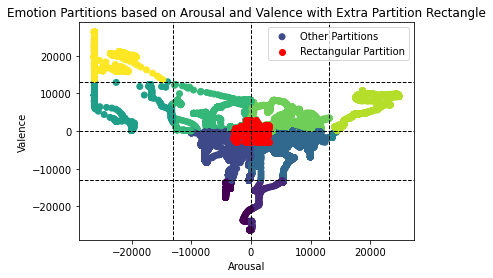

['Confident or Attentive' 'Polite or Sleepy' 'Tired or Bored'
 'Pleased or Glad' 'Delighted or Happy' 'Passionate or Amused'
 'Frustrated or Impatient' 'Worried or Apathetic'
 'Frustrated or Discontented' 'Distressed or Defiant']
        valence  arousal  video_x                 Emotion      ecg        bvp  \
10725    3621.0   -981.0      4.0  Confident or Attentive  0.66862  36.622646   
10726    3621.0   -981.0      4.0  Confident or Attentive  0.88546  36.031847   
10727    3621.0   -981.0      4.0  Confident or Attentive  0.79676  37.562205   
10728    3621.0   -981.0      4.0  Confident or Attentive  0.74748  36.855133   
10730    3621.0   -981.0      4.0  Confident or Attentive  0.67848  36.477363   
...         ...      ...      ...                     ...      ...        ...   
204550   3221.0     88.0      4.0    Passionate or Amused  0.73762  37.097290   
204551   3221.0     88.0      4.0    Passionate or Amused  0.81648  37.261912   
204553   3049.0     88.0      4.0    Pass

In [17]:
#FOR 20-24 AGE CATEGORY all merged

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


# Preprocess data for the current subject
merged_data_1 = preprocess_data(
    f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/boring_annotations.csv',
    f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/boring_physiological.csv'
)
    

merged_data_1['valence'] = merged_data_1['valence'].fillna(method="ffill")
merged_data_1['arousal'] = merged_data_1['arousal'].fillna(method="ffill")
merged_data_1 = merged_data_1[merged_data_1['video_x'] == merged_data_1['video_y']]
merged_data_1 = merged_data_1[merged_data_1['Emotion'] != 'Neutral']
sub_data = merged_data_1.drop('time', axis=1)
print(sub_data['Emotion'].unique())
print(sub_data)
print(len(sub_data))
label_encoder = LabelEncoder()
X=sub_data.drop(['Emotion','valence','arousal','video_y','video_x'],axis=1)
y=sub_data['Emotion']
y_encoded = label_encoder.fit_transform(sub_data['Emotion'])
encoded_classes = label_encoder.classes_
y = y_encoded

print(len(X))
print(len(y))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)





TIME to interpret

 92.82295036315918 seconds


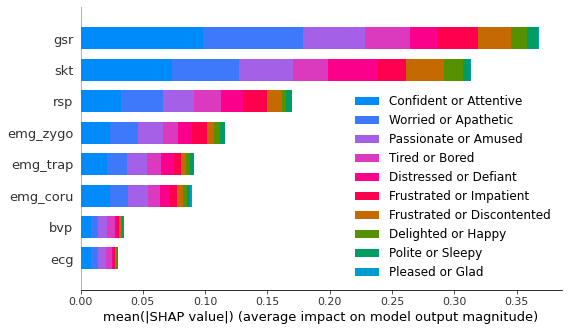

In [18]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
t0 = time.time()
explainerRF = shap.TreeExplainer(rf)
shap_values_RF_test = explainerRF.shap_values(X_test[0:100])
t1 = time.time()
timeit=t1-t0
print("TIME to interpret\n\n",timeit, "seconds")
categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x]))
for x in range(X_train.values.shape[1])]) <= 10).flatten()

class_names = encoded_classes
shap.summary_plot(shap_values_RF_test, X_test,class_names=class_names)


In [19]:
y_test

array([5, 4, 2, ..., 9, 2, 5])

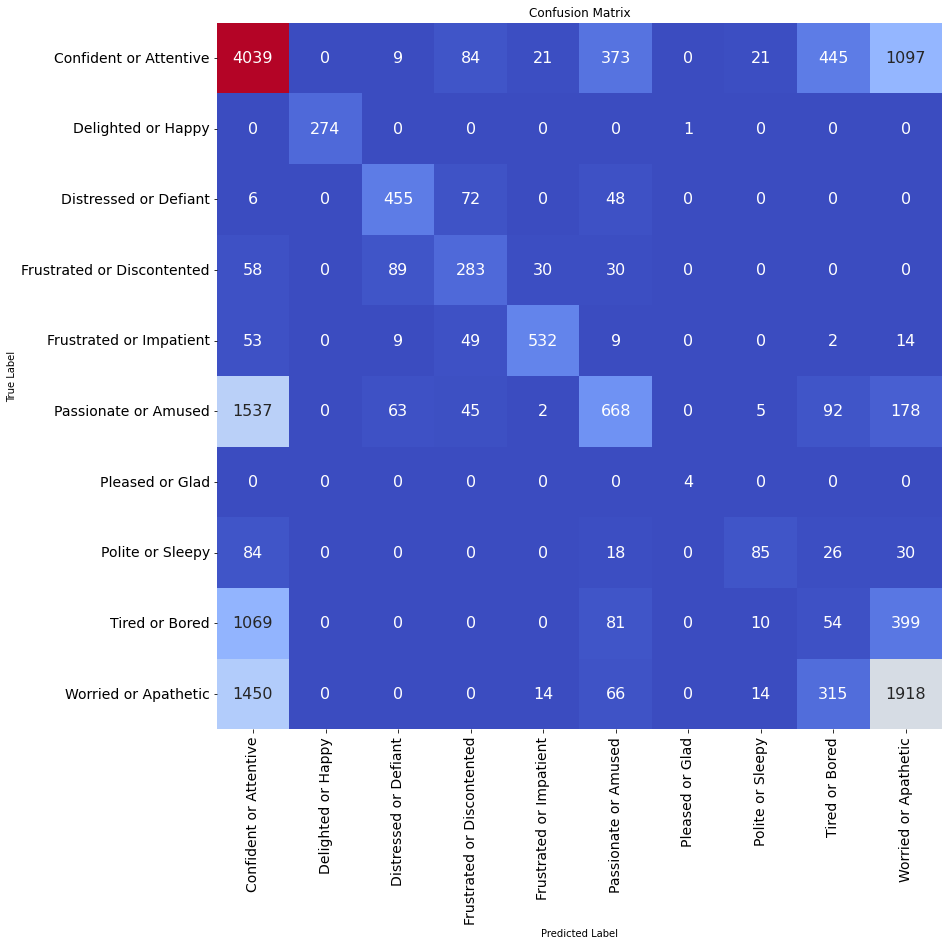

<Figure size 432x288 with 0 Axes>

In [20]:

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Extract unique labels from y_test
unique_labels = sorted(set(y_test))

# Create a filtered list of class names
filtered_class_names = [class_names[i] for i in unique_labels]

plt.figure(figsize=(13, 13))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False,
            xticklabels=filtered_class_names,
            yticklabels=filtered_class_names,
            annot_kws={"size": 16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
plt.savefig("amusing_confusion_matrix.png", bbox_inches='tight', dpi=300)


0.5090018371096142


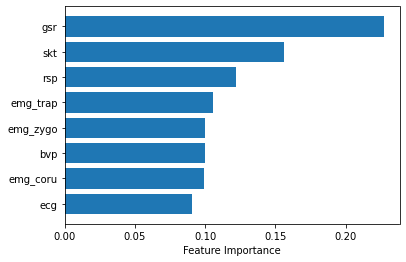

In [21]:
print(accuracy_score(y_test,y_pred))
feature_importances = rf.feature_importances_

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plotting the feature importances
plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.show()

In [22]:
instance_index = 99
print(X_test.iloc[instance_index])
print(class_names[y_test[instance_index]])
for i in range(len(class_names)):
    print(class_names[i])
    print(shap_values_RF_test[i][instance_index][:])

ecg          0.694900
bvp         37.872169
gsr         31.040112
rsp         43.619908
skt         32.456949
emg_zygo     8.766500
emg_coru     5.727500
emg_trap    10.573500
Name: 20714, dtype: float64
Confident or Attentive
Confident or Attentive
[-0.00362184 -0.01121867  0.12017682  0.03965879  0.27093187  0.04921271
  0.04314755  0.05184534]
Delighted or Happy
[-0.00106313  0.00321427  0.04223543  0.01366672  0.00114985 -0.02121583
 -0.00449439 -0.0098833 ]
Distressed or Defiant
[ 0.00144657  0.00380175 -0.01015532 -0.03015825  0.00685836  0.00440571
  0.01139552 -0.02175632]
Frustrated or Discontented
[ 4.98050644e-05 -2.19217430e-03 -1.96867138e-02 -2.32075241e-02
  1.97026832e-02 -1.39579316e-03  2.35944721e-05 -2.52244447e-03]
Frustrated or Impatient
[-0.00131682 -0.00014389 -0.0133848  -0.01588408 -0.00315925 -0.0047135
  0.00011028 -0.00018629]
Passionate or Amused
[ 0.00386566  0.00118521  0.01349683 -0.01149983 -0.14555457 -0.01030519
  0.00362022 -0.01446952]
Pleased or G

In [23]:
colour_scheme = 'cool'

FOR  Confident or Attentive


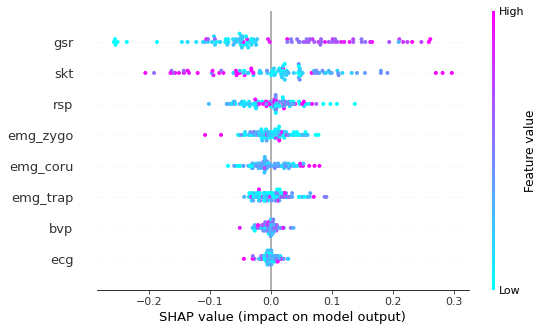

<Figure size 432x288 with 0 Axes>

FOR  Delighted or Happy


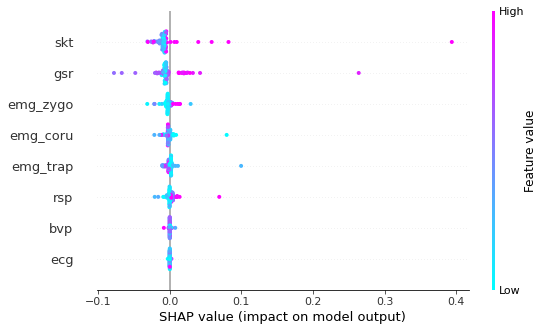

<Figure size 432x288 with 0 Axes>

FOR  Distressed or Defiant


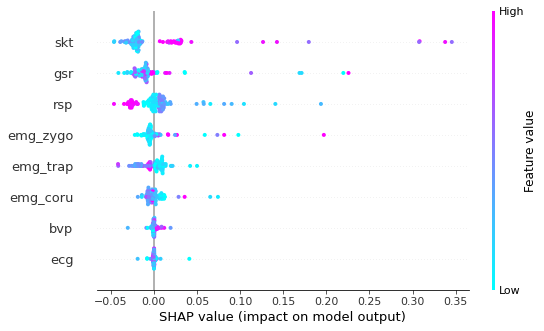

<Figure size 432x288 with 0 Axes>

FOR  Frustrated or Discontented


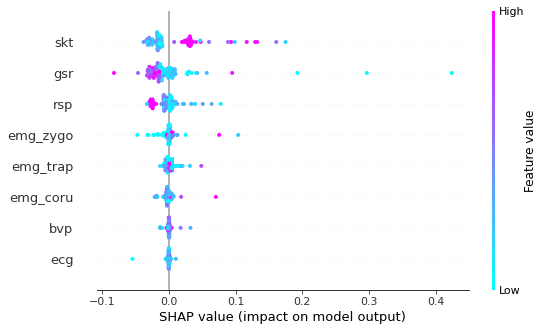

<Figure size 432x288 with 0 Axes>

FOR  Frustrated or Impatient


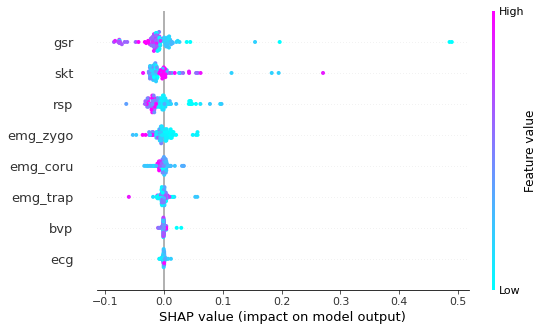

<Figure size 432x288 with 0 Axes>

FOR  Passionate or Amused


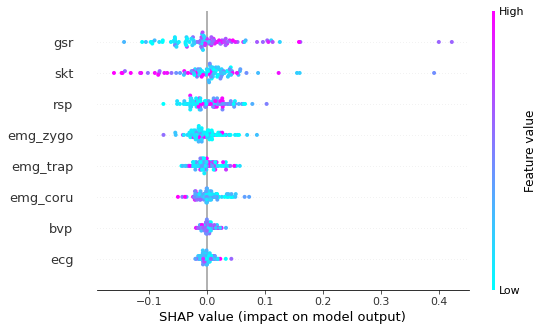

<Figure size 432x288 with 0 Axes>

FOR  Pleased or Glad


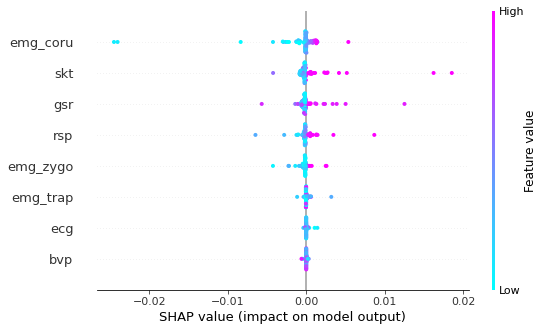

<Figure size 432x288 with 0 Axes>

FOR  Polite or Sleepy


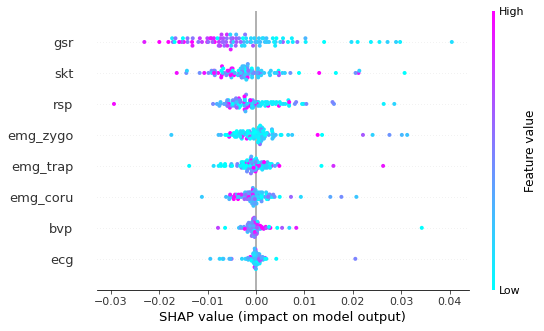

<Figure size 432x288 with 0 Axes>

FOR  Tired or Bored


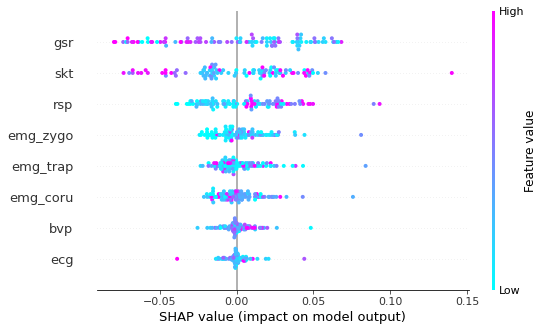

<Figure size 432x288 with 0 Axes>

FOR  Worried or Apathetic


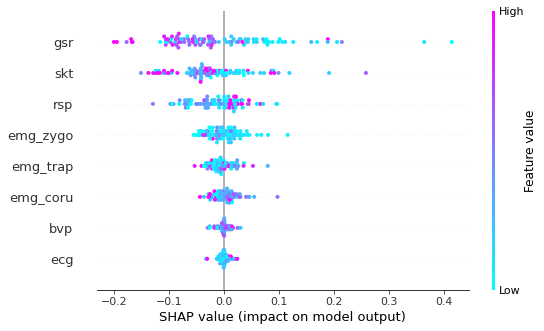

<Figure size 432x288 with 0 Axes>

In [24]:
class_names = encoded_classes

for i in range(0,len(class_names)):
    print("FOR ",class_names[i])
    shap.summary_plot(shap_values_RF_test[i],X_test[0:100],class_names=class_names,max_display = 8,cmap=colour_scheme)
    plt.tight_layout()
    plt.savefig('shap_summary_plot.png', bbox_inches='tight')
    plt.show()

FOR  Confident or Attentive


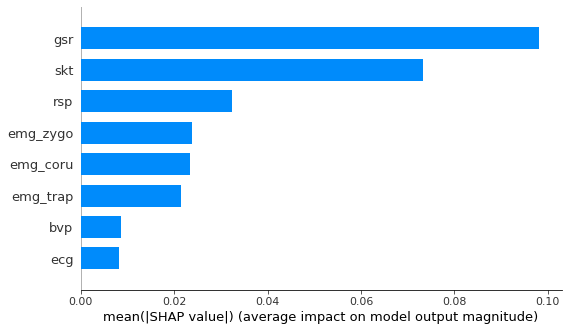

FOR  Delighted or Happy


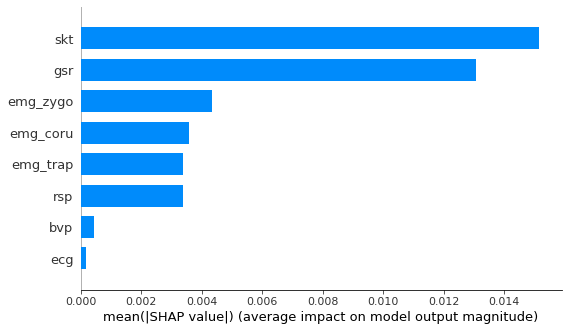

FOR  Distressed or Defiant


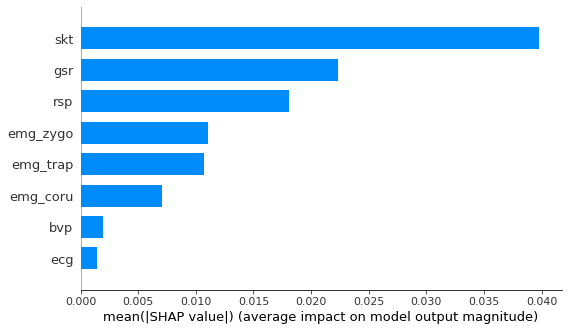

FOR  Frustrated or Discontented


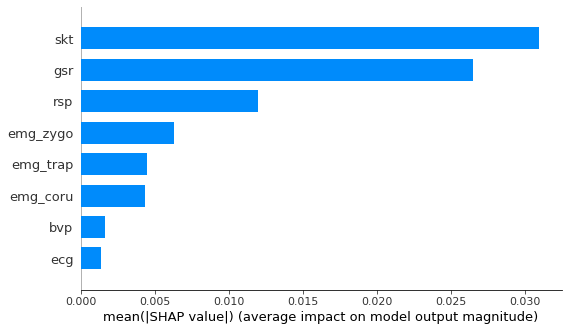

FOR  Frustrated or Impatient


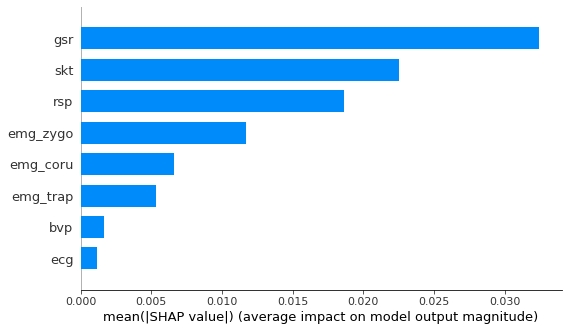

FOR  Passionate or Amused


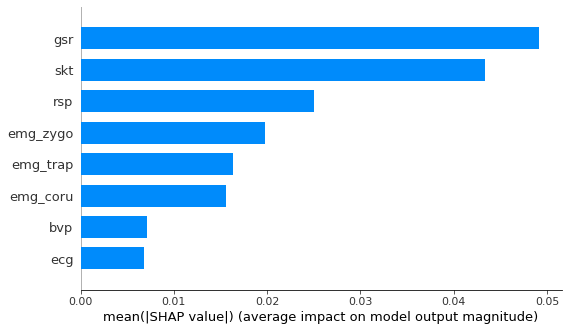

FOR  Pleased or Glad


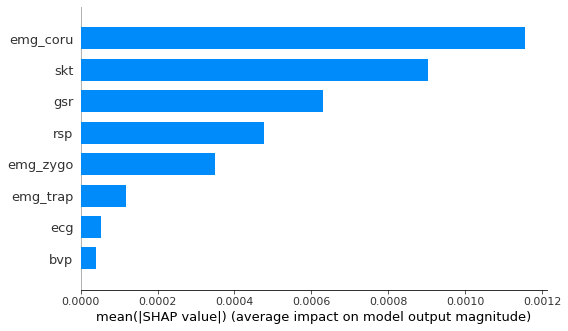

FOR  Polite or Sleepy


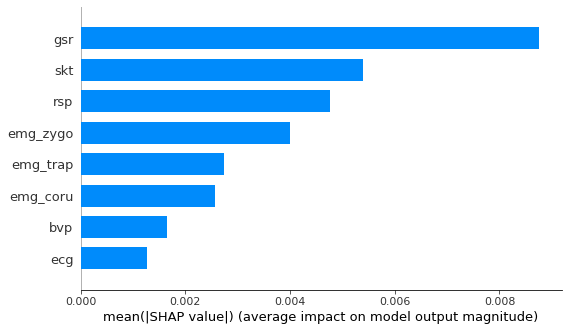

FOR  Tired or Bored


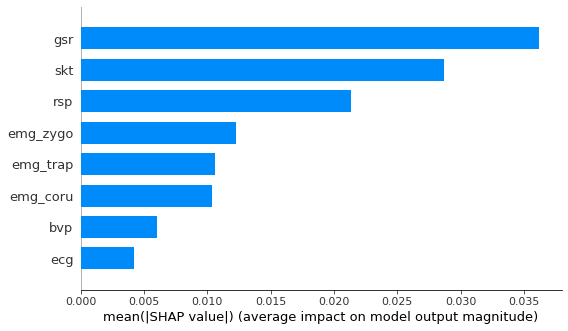

FOR  Worried or Apathetic


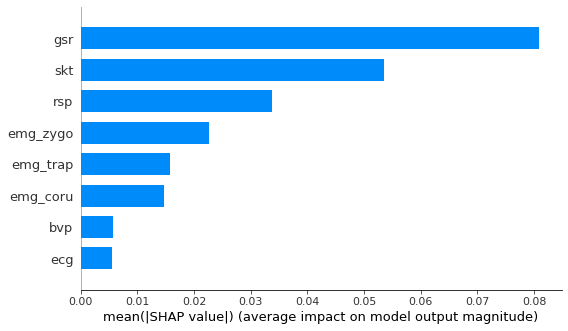

<Figure size 432x288 with 0 Axes>

In [25]:
class_names = encoded_classes

for i in range(0,len(class_names)):
    print("FOR ",class_names[i])
    shap.summary_plot(shap_values_RF_test[i],X_test[0:100],class_names=class_names,max_display = 8,plot_type="bar")

plt.tight_layout()

# Save or show the plot
plt.savefig('shap_summary_plot.png', bbox_inches='tight')
plt.show()

In [26]:
shap.initjs()
from IPython.display import display
print(X_test.iloc[instance_index])
print(class_names[y_test[instance_index]])

for i in range(len(class_names)):
    print("CLASS ",class_names[i])
    display(shap.force_plot(explainerRF.expected_value[i], shap_values_RF_test[i][instance_index][:], X_test.iloc[[instance_index]], plot_cmap="GnPR"))
    print("CLASS ",class_names[i])
    display(shap.force_plot(explainerRF.expected_value[i], shap_values_RF_test[i][:][:], X_test.iloc[0:100],plot_cmap="GnPR"))

ecg          0.694900
bvp         37.872169
gsr         31.040112
rsp         43.619908
skt         32.456949
emg_zygo     8.766500
emg_coru     5.727500
emg_trap    10.573500
Name: 20714, dtype: float64
Confident or Attentive
CLASS  Confident or Attentive


CLASS  Confident or Attentive


CLASS  Delighted or Happy


CLASS  Delighted or Happy


CLASS  Distressed or Defiant


CLASS  Distressed or Defiant


CLASS  Frustrated or Discontented


CLASS  Frustrated or Discontented


CLASS  Frustrated or Impatient


CLASS  Frustrated or Impatient


CLASS  Passionate or Amused


CLASS  Passionate or Amused


CLASS  Pleased or Glad


CLASS  Pleased or Glad


CLASS  Polite or Sleepy


CLASS  Polite or Sleepy


CLASS  Tired or Bored


CLASS  Tired or Bored


CLASS  Worried or Apathetic


CLASS  Worried or Apathetic


In [27]:
import time
start = time.time()
explanation = explainerRF(X_test[0:100])
end = time.time()
print(end-start)

110.17809343338013


In [28]:
# shap.plots.force(explanation[0])
np.array(explanation).shape
print(X_test)
feature_names = ['ecg','bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap']

            ecg        bvp        gsr        rsp        skt  emg_zygo  \
117012  0.81976  36.002778  23.340240  34.947149  22.328831   4.82400   
62586   0.89532  36.835734   8.638464  31.539986  22.300767   5.23475   
65059   0.58320  36.215867  24.810816  31.733548  27.121187  30.28625   
14314   1.17458  35.256968  27.282816  43.581196  31.941607   8.10950   
117499  0.78690  36.671113  40.750752  31.307653  24.576017   5.02950   
...         ...        ...        ...        ...        ...       ...   
109042  0.75076  35.247298  13.341912  31.297989  25.333259  13.11975   
152382  0.79018  36.884201  11.567760  35.218136  20.088645   5.72750   
155720  0.77376  35.169763  29.699616  43.794143  31.899544   6.75425   
65581   0.65876  36.506432  30.602472  35.227859  27.110666   7.94525   
118937  0.91174  35.934972  24.641304  29.855731  23.268368   4.61875   

        emg_coru  emg_trap  
117012  11.55925  10.61475  
62586    6.63100   9.01300  
65059    5.72750  16.56950  
14314  

CLASS NAME  Confident or Attentive


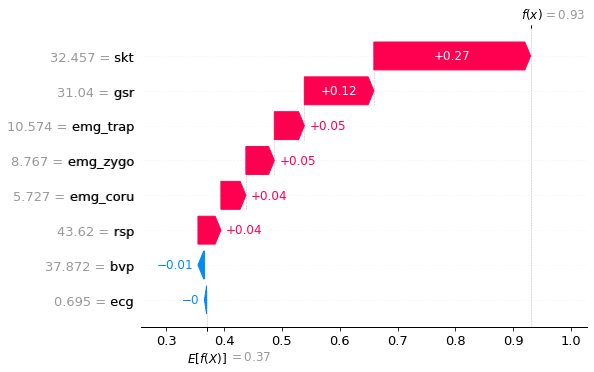

CLASS NAME  Delighted or Happy


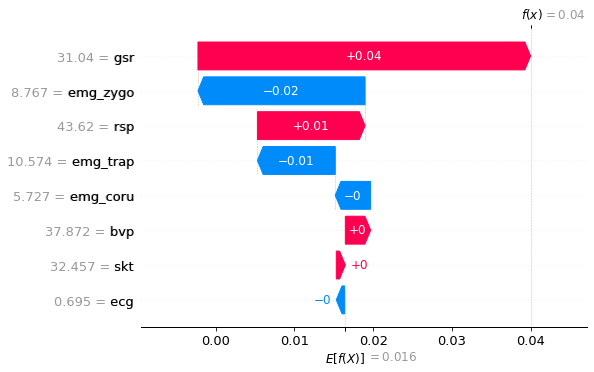

CLASS NAME  Distressed or Defiant


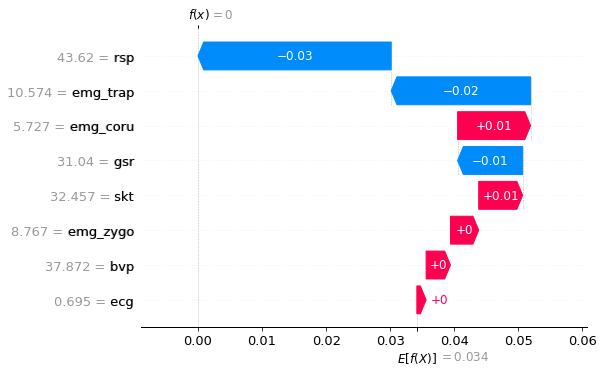

CLASS NAME  Frustrated or Discontented


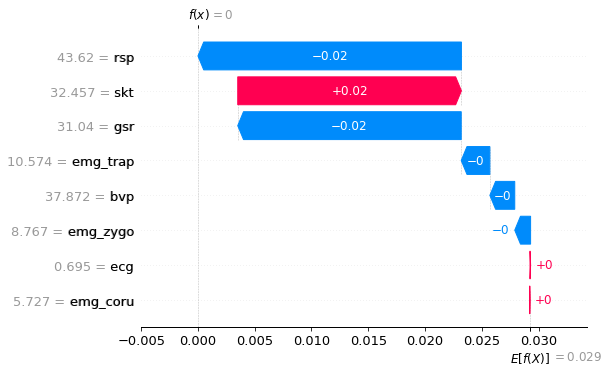

CLASS NAME  Frustrated or Impatient


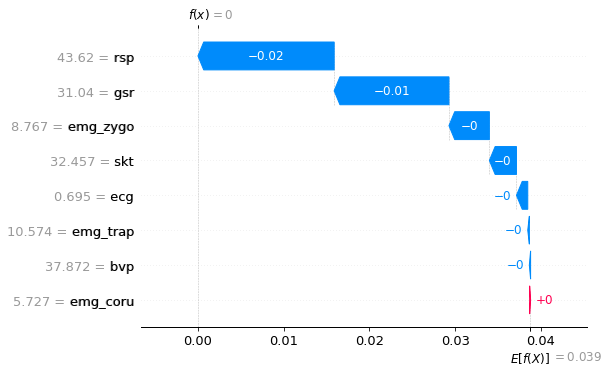

CLASS NAME  Passionate or Amused


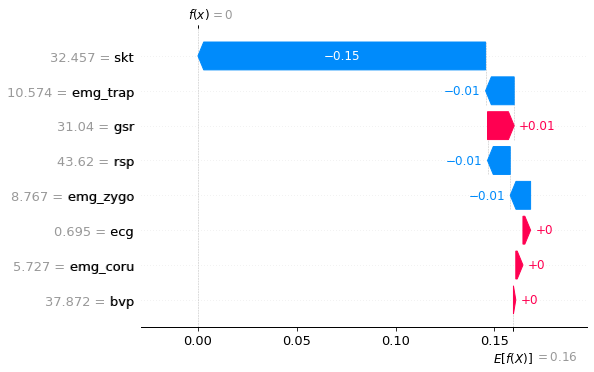

CLASS NAME  Pleased or Glad


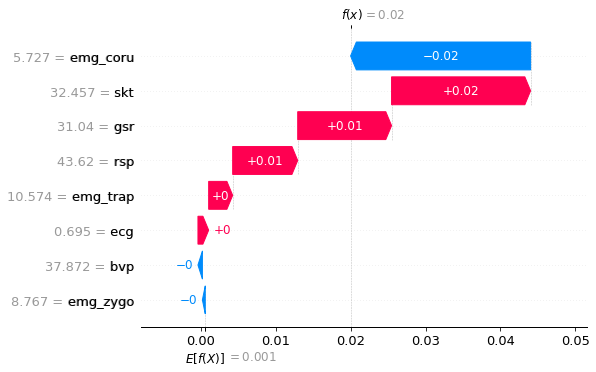

CLASS NAME  Polite or Sleepy


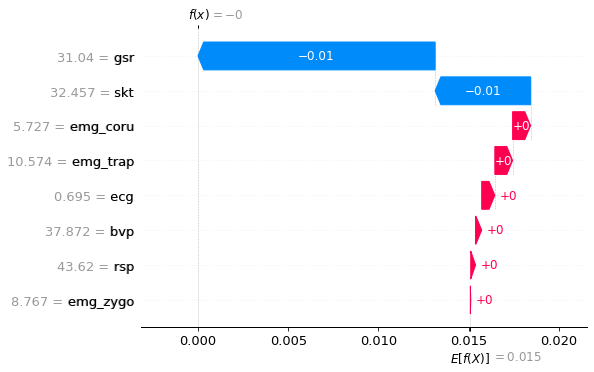

CLASS NAME  Tired or Bored


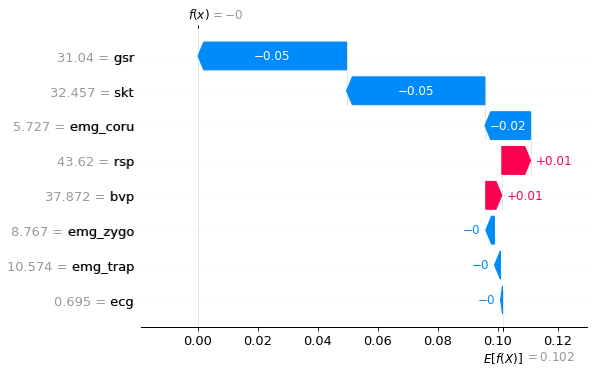

CLASS NAME  Worried or Apathetic


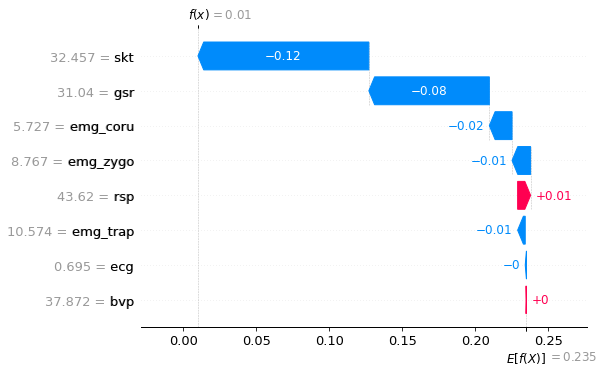

In [29]:
for i in range(len(class_names)):
    class_name = i
    print("CLASS NAME ", class_names[class_name])
    EXP = shap.Explanation(
        values=explanation[instance_index].values[:,class_name],
        base_values=explanation[instance_index].base_values[class_name],
        data = explanation[instance_index].data,
        feature_names = feature_names
    )
    shap.waterfall_plot(EXP,max_display = 8)

In [30]:
class_names[y_test[instance_index]]

'Confident or Attentive'

In [31]:
X_test.iloc[instance_index]

ecg          0.694900
bvp         37.872169
gsr         31.040112
rsp         43.619908
skt         32.456949
emg_zygo     8.766500
emg_coru     5.727500
emg_trap    10.573500
Name: 20714, dtype: float64

CLASS  Confident or Attentive


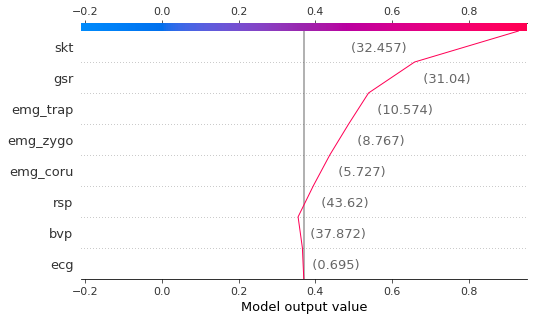

CLASS  Delighted or Happy


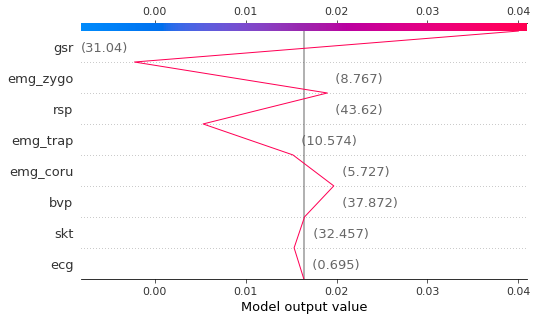

CLASS  Distressed or Defiant


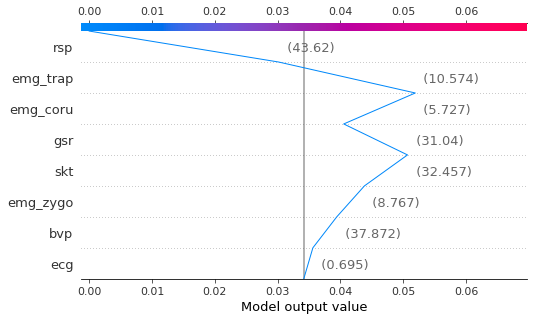

CLASS  Frustrated or Discontented


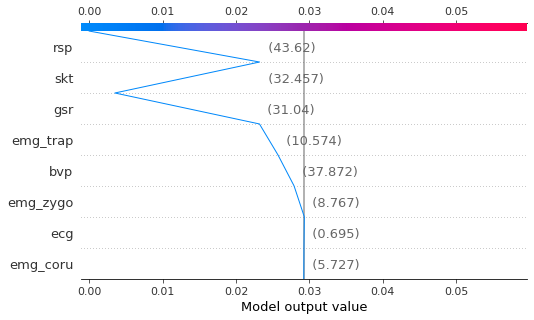

CLASS  Frustrated or Impatient


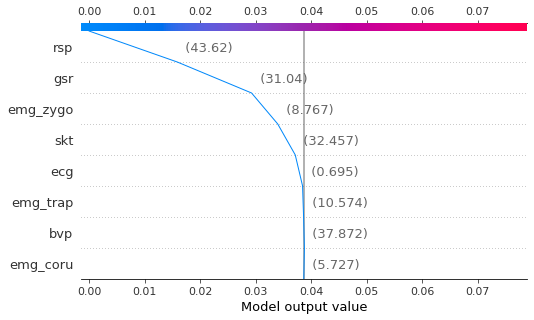

CLASS  Passionate or Amused


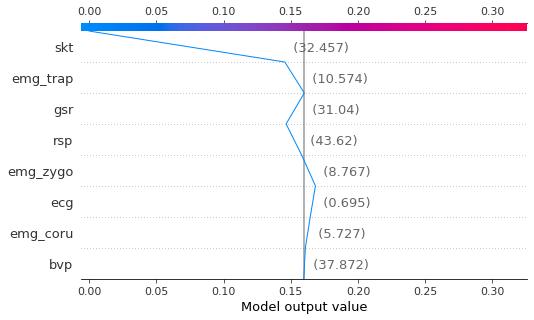

CLASS  Pleased or Glad


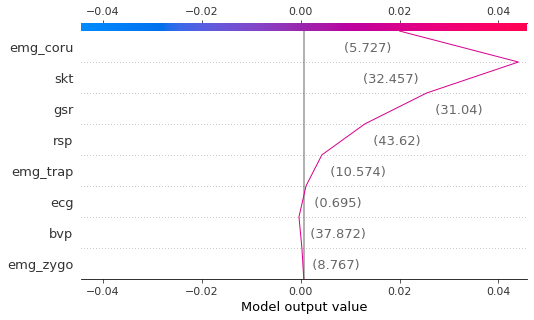

CLASS  Polite or Sleepy


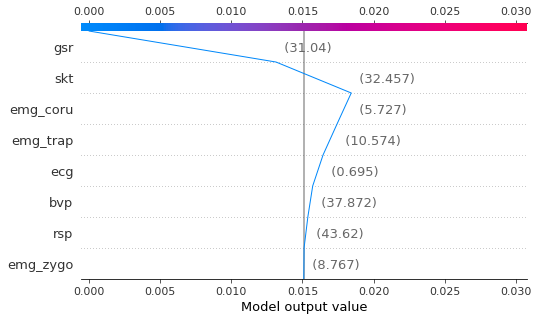

CLASS  Tired or Bored


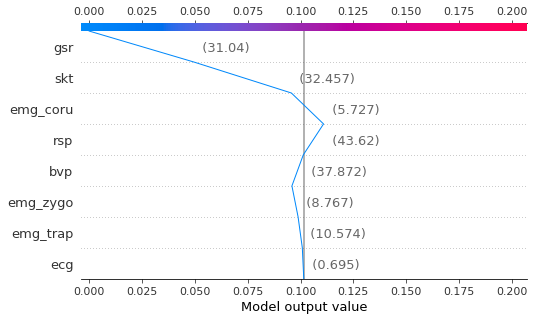

CLASS  Worried or Apathetic


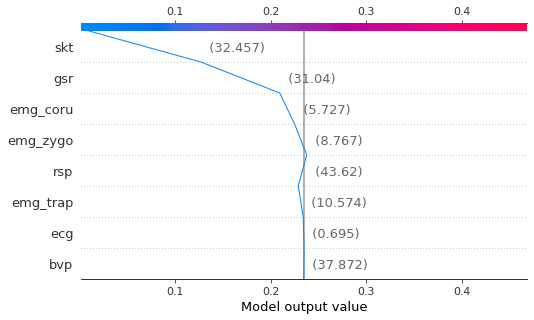

In [32]:
for i in range(len(class_names)):
    print("CLASS ",class_names[i])
    shap.decision_plot(explainerRF.expected_value[i], shap_values_RF_test[i][instance_index], X_test.iloc[instance_index])

In [33]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, feature_names=X_train.columns, mode="classification",kernel_width=0.5)
t0 = time.time()

explanations_test = []

explanation_lime = explainer.explain_instance(
    X_test.values[instance_index], rf.predict_proba, num_features=10, top_labels=14)
explanations_test.append(explanation_lime)

t1 = time.time()
timeit = t1 - t0
print("TIME to interpret\n\n", timeit, "seconds")

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


TIME to interpret

 6.663403511047363 seconds


In [34]:
explanation = explanations_test[0]
explanation.show_in_notebook()

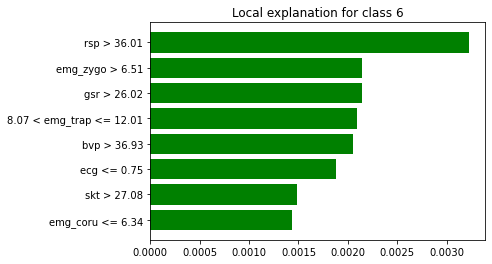

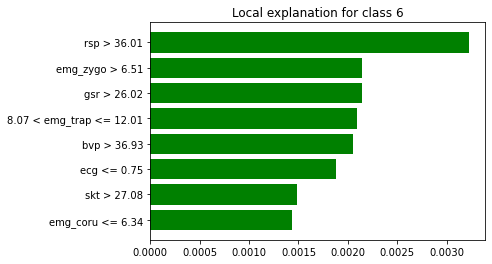

In [35]:
explanation.as_pyplot_figure(label=6)

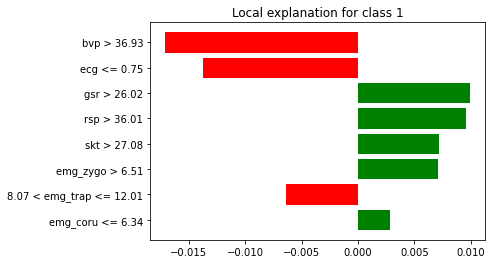

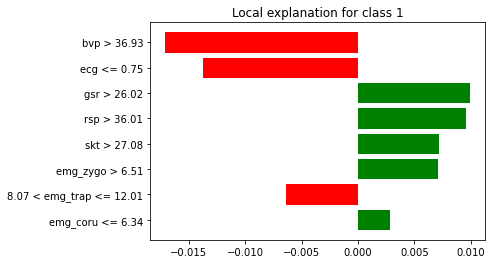

In [36]:
explanation.as_pyplot_figure(label=1)